**Set up notebook:**

In [1]:
#Configure Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Path to dataset folder
data_folder = '/content/drive/My Drive/MA/'

Mounted at /content/drive


In [ ]:
#Upload file locally
from google.colab import files

uploaded = files.upload()

In [2]:
#Import required libraries for this notebook
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns

**Load dataset:**

In [3]:
#Read data
signals = 'wind-farm-1-signals-training.csv'
signals_test = 'wind-farm-1-signals-testing.csv'
all_data = pd.concat([pd.read_csv(data_folder + signals, delimiter=';'), pd.read_csv(data_folder + signals_test, delimiter=';')], ignore_index=True)

#Filter T_09 data out
wtg_data = all_data[all_data.Turbine_ID == 'T11'].reset_index().drop(columns=['index'])

wtg_data['Timestamp'] = pd.to_datetime(wtg_data['Timestamp'])
wtg_data.set_index('Timestamp', inplace=True)
wtg_data.drop(columns=['Turbine_ID'], inplace=True)
#wtg_data = wtg_data[wtg_data['Grd_Prod_Pwr_Avg'] > 0]
print(wtg_data.dtypes)
wtg_data.head()

Gen_RPM_Max              float64
Gen_RPM_Min              float64
Gen_RPM_Avg              float64
Gen_RPM_Std              float64
Gen_Bear_Temp_Avg        float64
                          ...   
Grd_Prod_PsbleCap_Max    float64
Grd_Prod_PsbleCap_Min    float64
Grd_Prod_PsbleCap_Std    float64
Gen_Bear2_Temp_Avg         int64
Nac_Direction_Avg        float64
Length: 81, dtype: object


,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Nac_Temp_Avg,Rtr_RPM_Max,Rtr_RPM_Min,Rtr_RPM_Avg,Amb_WindSpeed_Max,Amb_WindSpeed_Min,Amb_WindSpeed_Avg,Amb_WindSpeed_Std,Amb_WindDir_Relative_Avg,Amb_WindDir_Abs_Avg,Amb_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_ActPwrGen1,Prod_LatestAvg_ActPwrGen2,Prod_LatestAvg_TotActPwr,Prod_LatestAvg_ReactPwrGen0,Prod_LatestAvg_ReactPwrGen1,Prod_LatestAvg_ReactPwrGen2,Prod_LatestAvg_TotReactPwr,HVTrafo_Phase1_Temp_Avg,HVTrafo_Phase2_Temp_Avg,HVTrafo_Phase3_Temp_Avg,Grd_InverterPhase1_Temp_Avg,Cont_Top_Temp_Avg,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Gen_SlipRing_Temp_Avg,Spin_Temp_Avg,Blds_PitchAngle_Min,...,Blds_PitchAngle_Avg,Blds_PitchAngle_Std,Cont_VCP_ChokcoilTemp_Avg,Grd_RtrInvPhase1_Temp_Avg,Grd_RtrInvPhase2_Temp_Avg,Grd_RtrInvPhase3_Temp_Avg,Cont_VCP_WtrTemp_Avg,Grd_Prod_Pwr_Avg,Grd_Prod_CosPhi_Avg,Grd_Prod_Freq_Avg,Grd_Prod_VoltPhse1_Avg,Grd_Prod_VoltPhse2_Avg,Grd_Prod_VoltPhse3_Avg,Grd_Prod_CurPhse1_Avg,Grd_Prod_CurPhse2_Avg,Grd_Prod_CurPhse3_Avg,Grd_Prod_Pwr_Max,Grd_Prod_Pwr_Min,Grd_Busbar_Temp_Avg,Rtr_RPM_Std,Amb_WindSpeed_Est_Avg,Grd_Prod_Pwr_Std,Grd_Prod_ReactPwr_Avg,Grd_Prod_ReactPwr_Max,Grd_Prod_ReactPwr_Min,Grd_Prod_ReactPwr_Std,Grd_Prod_PsblePwr_Avg,Grd_Prod_PsblePwr_Max,Grd_Prod_PsblePwr_Min,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,1339.4,1233.3,1270.9,18.8,42.0,59,61,60,30,48,55,27,11.9,10.9,11.3,8.6,2.6,5.3,0.7,-7.8,199.1,18,0,41059.0,0,41059.0,0,-13521,0,-13521,46,51,46,40,41,28,42,27,20,-2.1,...,-1.4,0.3,90,39,40,40,38,246.1,0.9,50.0,400.7,398.2,398.0,197.0,234.1,216.9,368.9,154.1,39,0.2,5.4,51.8,-81.1,-72.5,-100.1,5.0,245.9,373.9,153.6,51.7,-973.4,-752.6,-1000.0,56.5,973.4,1000.0,752.6,56.5,38,206.9
2016-01-01 00:10:00+00:00,1400.5,1239.8,1303.6,40.2,43.0,59,61,60,30,48,55,27,12.4,11.0,11.5,11.1,1.7,5.7,0.9,0.6,207.5,18,0,50808.0,0,50808.0,0,-15363,0,-15363,46,51,46,40,41,28,42,27,20,-2.2,...,-1.7,0.4,90,39,40,40,38,304.7,1.0,50.0,400.4,398.2,397.9,245.0,283.3,267.2,430.4,191.3,39,0.4,5.8,54.4,-92.1,-76.8,-102.0,5.8,305.4,439.5,190.1,54.8,-999.3,-931.3,-1000.0,5.8,999.3,1000.0,931.3,5.8,38,206.9
2016-01-01 00:20:00+00:00,1423.6,1270.8,1344.3,27.2,43.0,60,61,61,30,49,56,27,12.6,11.3,11.9,9.9,1.5,6.1,0.8,-16.5,190.5,18,0,60667.0,0,60667.0,0,-15724,0,-15724,46,52,46,40,41,28,43,27,20,-2.2,...,-1.9,0.2,90,39,40,40,38,364.2,1.0,50.0,399.8,397.7,397.3,292.3,331.9,317.9,468.3,211.3,39,0.2,6.1,49.7,-94.3,-33.7,-108.1,12.8,364.5,471.9,201.4,50.2,-1000.0,-986.9,-1000.0,0.2,1000.0,1000.0,986.9,0.2,38,206.9
2016-01-01 00:30:00+00:00,1470.1,1258.7,1377.5,48.9,43.0,60,62,61,30,49,57,27,13.0,11.2,12.2,9.4,2.7,6.3,0.8,7.6,214.6,18,0,77486.0,0,77486.0,0,-16447,0,-16447,47,52,47,40,41,28,43,27,20,-2.6,...,-2.0,0.2,90,39,41,40,38,465.0,1.0,50.0,399.6,397.3,397.0,374.6,414.7,401.7,581.2,316.5,39,0.4,6.5,59.5,-98.7,-88.7,-105.1,3.4,465.3,587.4,312.6,60.1,-1000.0,-1000.0,-1000.0,0.0,1000.0,1000.0,1000.0,0.0,38,206.9
2016-01-01 00:40:00+00:00,1539.1,1252.1,1396.2,66.8,43.0,61,62,61,30,50,57,27,13.6,11.1,12.4,11.6,1.7,6.4,0.9,5.2,212.1,18,0,67378.0,0,67378.0,0,-16343,0,-16343,47,52,47,39,41,28,43,27,20,-2.3,...,-2.0,0.3,90,39,40,40,39,404.6,1.0,50.0,398.8,396.7,396.6,327.7,367.0,351.2,641.9,204.3,40,0.6,6.3,98.6,-98.1,-91.1,-106.1,3.6,405.2,652.9,192.3,99.0,-999.9,-945.9,-1000.0,1.7,999.9,1000.0,945.9,1.7,39,206.9


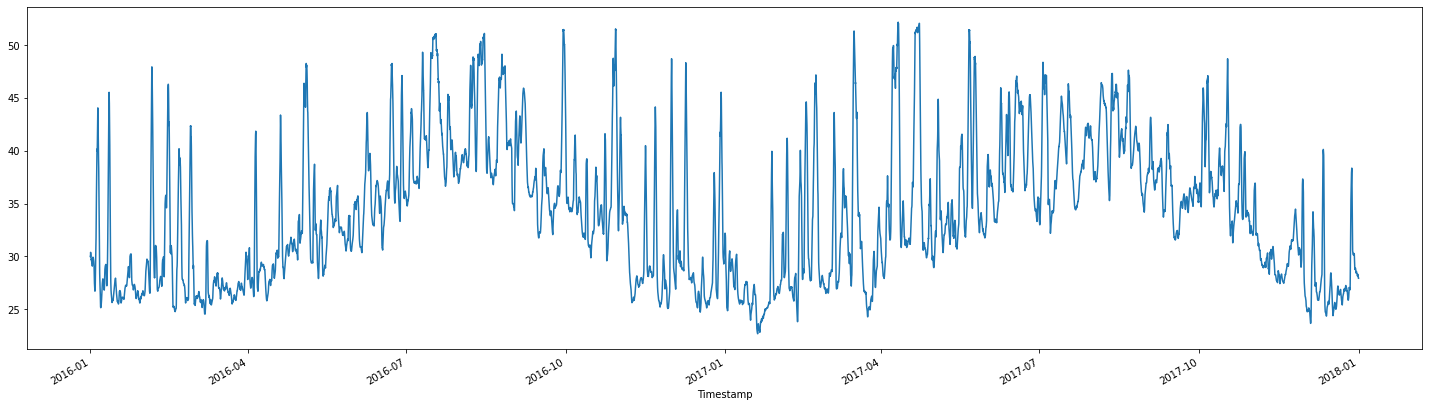

In [19]:
wtg_data['Hyd_Oil_Temp_Avg'].rolling('D').mean().plot(figsize=(25,7))

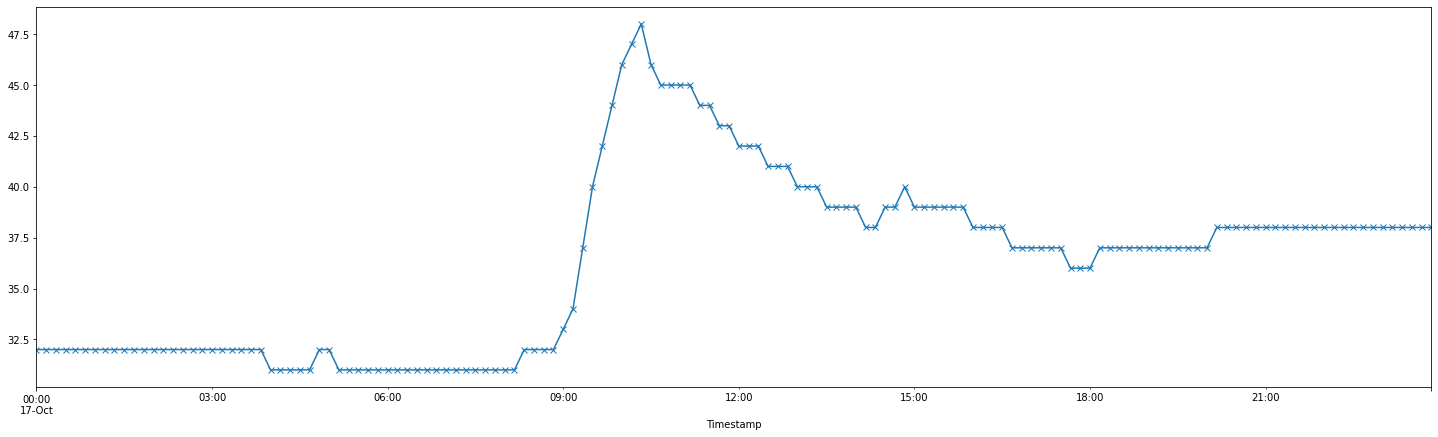

In [20]:
#Failure 1: October 17, 2016 5:44 PM Hydraulic group error in the brake circuit
wtg_data.loc['2016-10-17':'2016-10-17']['Hyd_Oil_Temp_Avg'].plot(figsize=(25,7), marker='x')

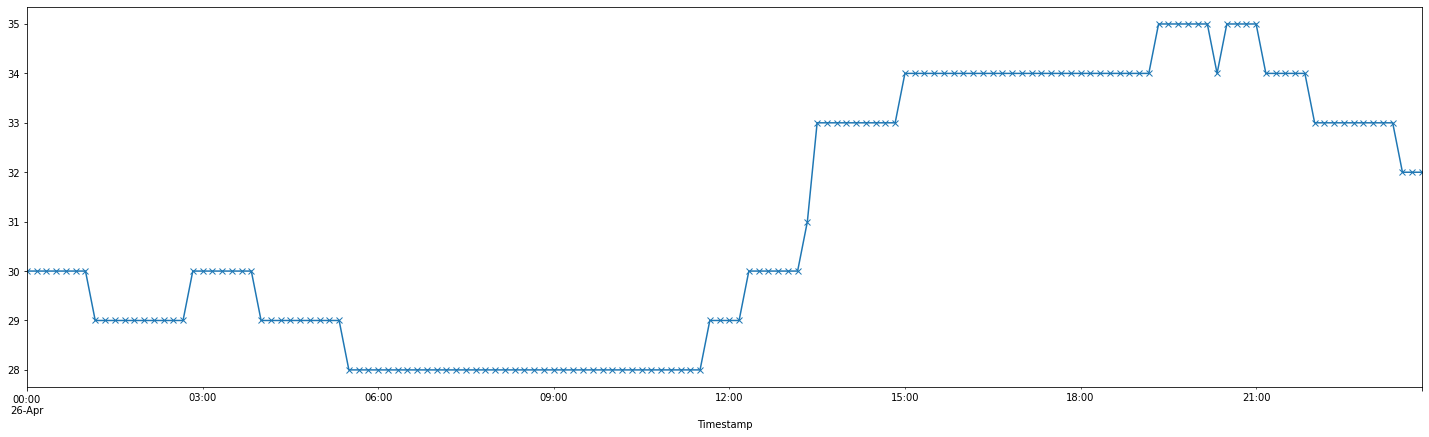

In [21]:
#Failure2: April 26, 2017 6:06 PM Hydraulic group error in the brake circuit
wtg_data.loc['2016-04-26':'2016-04-26']['Hyd_Oil_Temp_Avg'].plot(figsize=(25,7), marker='x')

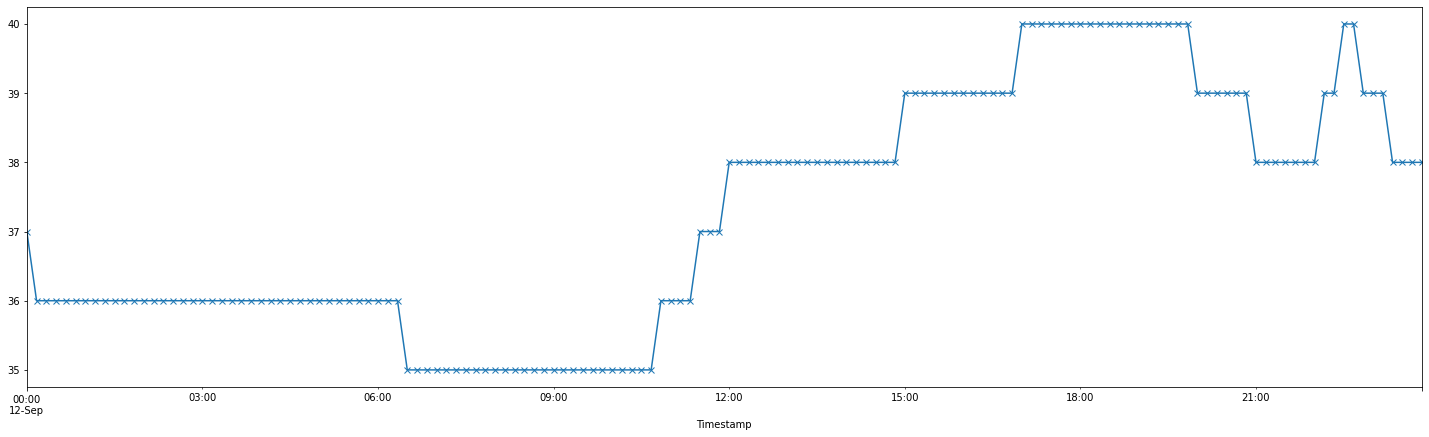

In [22]:
#Failure 3: September 12, 2017 3:30 PM Hydraulic group error in the brake circuit
wtg_data.loc['2016-09-12':'2016-09-12']['Hyd_Oil_Temp_Avg'].plot(figsize=(25,7), marker='x')

In [27]:
#Temp range:
print('Temperature Range: {}-{}'.format(str(wtg_data['Hyd_Oil_Temp_Avg'].min()), str(wtg_data['Hyd_Oil_Temp_Avg'].max())))

Temperature Range: 20-55


In [ ]:
#==========================================================================================================================================

**Feature Selection:**

In [ ]:
#Create Kendall's correlation matrix for column 'Hyd_Oil_Temp_Avg'
for periods in [0, 1, 2, 3]:
  corr = wtg_data.shift(periods=periods).corrwith(wtg_data['Hyd_Oil_Temp_Avg'], method='kendall')
  pd.DataFrame(corr[(corr >= 0.5) | (corr <= -0.5)]).to_excel('corr_lag_{}.xls'.format(periods))
  files.download('corr_lag_{}.xls'.format(periods))

Selected Features (From highest to lowest correlation): ['Nac_Temp_Avg', 'Gen_SlipRing_Temp_Avg', 'Cont_Top_Temp_Avg', 'Amb_Temp_Avg']

In [30]:
features = ['Nac_Temp_Avg', 'Gen_SlipRing_Temp_Avg', 'Cont_Top_Temp_Avg', 'Amb_Temp_Avg', 'Hyd_Oil_Temp_Avg']

In [31]:
#Normalize data to look at features together on one graph
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(wtg_data)

wtg_data_normalized = pd.DataFrame(scaler.transform(wtg_data), columns=wtg_data.columns, index=wtg_data.index)

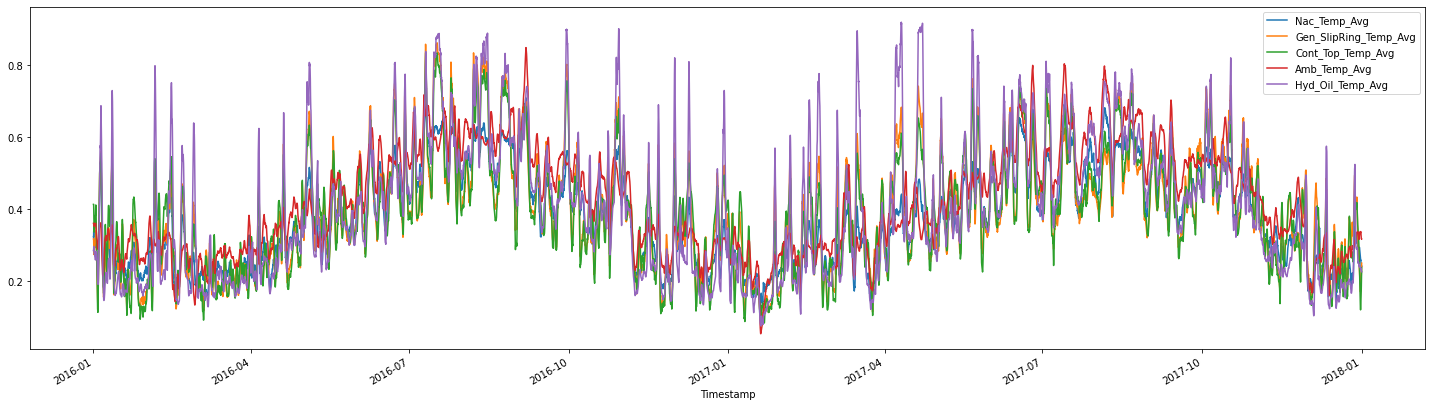

In [32]:
wtg_data_normalized[features].rolling('D').mean().plot(figsize=(25,7))